In [467]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import auc, accuracy_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import seaborn as sns

from scipy.stats import shapiro
from scipy.stats import ttest_rel

from itertools import combinations
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

In [116]:
def mean_encode(x_train, x_test, y_train, y_test, column):
    
    """Function for mean encoding of categorical features using K-Fold regularization scheme"""
    
    kf = KFold(n_splits=5, random_state=0)
    
    x_train['target'] = y_train
    x_test['target'] = y_test
    target = 'target'
        
    df_train = pd.DataFrame(index = x_train.index, columns = ['mean_enc_' + column])
    df_test = pd.DataFrame(index = x_test.index, columns = ['mean_enc_' + column])
    
    for train_index, val_index in kf.split(x_train):
        train = x_train.iloc[train_index]
        val = x_train.iloc[val_index]
            
        df_train['mean_enc_' + column].iloc[val_index] = val[column].map(train.groupby(column)[target].mean()).values

    global_mean = x_train[target].mean()
    
    df_test['mean_enc_' + column] = x_test[column].map(x_train.groupby(column)[target].mean())
    
    x_train.drop('target', axis=1, inplace=True)
    x_test.drop('target', axis=1, inplace=True)    
    
    x_train['mean_enc_' + column] = df_train['mean_enc_' + column].fillna(global_mean).values
    x_test['mean_enc_' + column] = df_test['mean_enc_' + column].fillna(global_mean).values
    
    return

def freq_encode(train, test, column):
    
    """Function for frequency encoding of categorical features"""
       
    train['freq_'+column] = train[column].map(train.groupby(column).size())/train.shape[0]
    test['freq_'+column] = test[column].map(pd.concat([train, test], sort=False
                                                     ).groupby(column).size())/(train.shape[0]+test.shape[0])
    
    return

In [150]:
df = pd.read_csv('heart.csv')

In [151]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [45]:
df.cp.value_counts()

0    143
2     87
1     50
3     23
Name: cp, dtype: int64

In [51]:
df.restecg.value_counts()

1    152
0    147
2      4
Name: restecg, dtype: int64

In [48]:
df.slope.value_counts()

2    142
1    140
0     21
Name: slope, dtype: int64

In [49]:
df.ca.value_counts()

0    175
1     65
2     38
3     20
4      5
Name: ca, dtype: int64

In [50]:
df.thal.value_counts()

2    166
3    117
1     18
0      2
Name: thal, dtype: int64

In [26]:
df.target.value_counts()

1    165
0    138
Name: target, dtype: int64

In [54]:
# Split features into numeric, binary and categorical

numeric = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
binary = ['sex', 'fbs', 'exang']
categorical = ['cp', 'restecg', 'slope', 'ca', 'thal']

In [58]:
assert len(numeric) + len(binary) + len(categorical) == df.shape[1] - 1

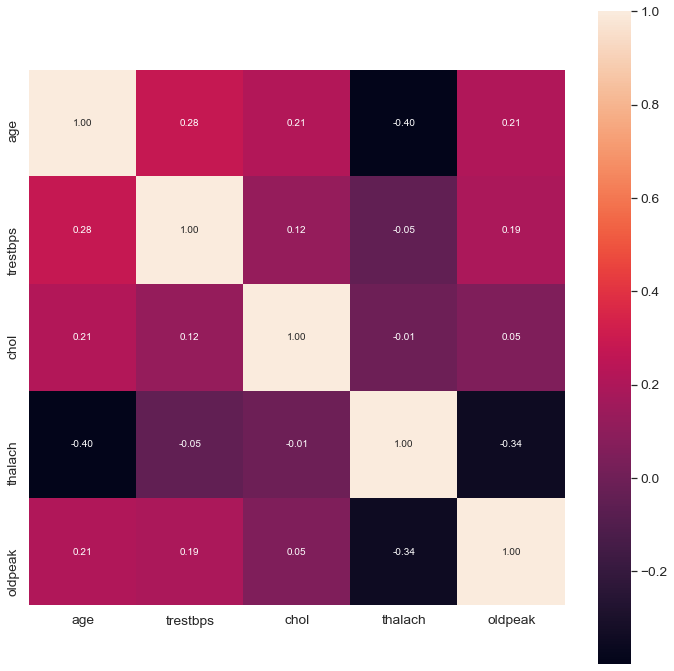

In [128]:
# Look at correlations of numeric features

corrmat = df[numeric].corr()
plt.figure(figsize=(12,12))
cols = numeric
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols, xticklabels=cols)
plt.show()

In [152]:
X = df.drop('target', axis=1)
y = df.target
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

#### Baseline model

In [688]:
# Get accuracy scores from 9 folds in 9-fold CV scheme without splitting data into train / test
# since dataset is small

kf = KFold(n_splits=9, shuffle=True)
baseline_acc = []

for train_index, val_index in kf.split(X):
    train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    val = X.iloc[val_index]
    y_val = y.iloc[val_index]
    
    rfc.fit(train, y_train)
    y_preds = rfc.predict(val)
    baseline_acc.append(accuracy_score(y_val, y_preds))
    
print(f'Mean accuracy score of baseline model: {sum(baseline_acc) / len(baseline_acc)}')

Mean accuracy score of baseline model: 0.8178847296494357


In [689]:
# The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.
# This test is required to make sure response of 9-fold crocc-validation can be used to compare means
# of other models responses using relative student test (scipy.ttest_rel)
shapiro(baseline_acc)
# p-value > 0.05 =>> cannot reject null-hypothesis => accept responses are drawn from normal distribution

ShapiroResult(statistic=0.8751119375228882, pvalue=0.13940657675266266)

#### Brute force original features selection

In [316]:
# Use 9-fold cross-validaton without train-test splitting since dataset is small

for cols_number in tqdm_notebook(range(2, X.columns.values.shape[0])):
    for cols_set in tqdm_notebook(combinations(X.columns.values, cols_number)):
        
        kf = KFold(n_splits=9, shuffle=True, random_state=0)
        accuracies = []

        for train_index, val_index in kf.split(X):
            train = X[list(cols_set)].iloc[train_index]
            y_train = y.iloc[train_index]
            val = X[list(cols_set)].iloc[val_index]
            y_val = y.iloc[val_index]

            rfc.fit(train, y_train)
            y_preds = rfc.predict(val)
            accuracies.append(accuracy_score(y_val, y_preds))
        
        mean_accuracy = sum(accuracies) / len(accuracies)
        mean_baseline_accuracy = sum(baseline_acc) / len(baseline_acc)
 
        if mean_accuracy > mean_baseline_accuracy:
            best_cols_set = list(cols_set)
            print(f'mean_accuracy: {mean_accuracy}')
            print(f'baseline_accuracy: {mean_baseline_accuracy}')
            print(f'ttest: {ttest_rel(accuracies, baseline_acc)}')
            print(cols_set)
            baseline_acc = accuracies

  0%|          | 0/11 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

mean_accuracy: 0.8381857793622499
baseline_accuracy: 0.8183798772034065
ttest: Ttest_relResult(statistic=0.8079950749618295, pvalue=0.4424545168655888)
('cp', 'ca', 'thal')
mean_accuracy: 0.8387799564270152
baseline_accuracy: 0.8381857793622499
ttest: Ttest_relResult(statistic=0.028095263976658267, pvalue=0.9782743932382283)
('exang', 'ca', 'thal')


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

mean_accuracy: 0.8417508417508417
baseline_accuracy: 0.8387799564270152
ttest: Ttest_relResult(statistic=0.20657012916508952, pvalue=0.8415061329721587)
('sex', 'trestbps', 'fbs', 'exang', 'ca', 'thal')
mean_accuracy: 0.8546246781540899
baseline_accuracy: 0.8417508417508417
ttest: Ttest_relResult(statistic=0.6682479929888075, pvalue=0.5227841046145221)
('cp', 'trestbps', 'restecg', 'slope', 'ca', 'thal')


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [328]:
# Selected columns set producing maximum accuracy score in 9-fold cross-validation scheme
best_cols_set

['cp', 'trestbps', 'restecg', 'slope', 'ca', 'thal']

#### Test intercation of numeric features of type feature1 / feature2

In [329]:
# Generating varios features of type "numeric feature 1" / "numeric feature 2"

extra_numeric_feats = pd.DataFrame(index=X.index)
paired_columns = []

for pair in list(combinations(numeric, 2)):
    col0 = pair[0]
    col1 = pair[1]
    if pair[1] == 'oldpeak':
        col0, col1 = col1, col0
    new_column_name = col0 + '_' + col1
    paired_columns.append(new_column_name)
    extra_numeric_feats[new_column_name] = X[col0] / X[col1]
    
    col0, col1 = col1, col0
    if col1 == 'oldpeak':
        continue
        
    new_column_name = col0 + '_' + col1
    paired_columns.append(new_column_name)
    extra_numeric_feats[new_column_name] = X[col0] / X[col1]

In [332]:
# test features of type "numeric feature 1" / "numeric feature 2"

selected_cols = []
X_train = X[best_cols_set].copy()

for col in tqdm_notebook(extra_numeric_feats.columns):
    
    X_expanded = X_train.join(extra_numeric_feats[col])
    kf = KFold(n_splits=9, shuffle=True)
    accuracies = []

    for train_index, val_index in kf.split(X):
        train = X_expanded.iloc[train_index].copy()
        y_train = y.iloc[train_index]
        val = X_expanded.iloc[val_index].copy()
        y_val = y.iloc[val_index]
        
        rfc.fit(train, y_train)
        y_preds = rfc.predict(val)
        accuracies.append(accuracy_score(y_val, y_preds))
        
    mean_accuracy = sum(accuracies) / len(accuracies)
    mean_baseline = sum(baseline_acc) / len(baseline_acc)
        
    #print(f'mean accuracy difference: {mean_accuracy - mean_baseline}, ttest: {ttest_rel(accuracies, baseline_acc)}')
    
    if (mean_accuracy > mean_baseline):
        selected_cols.append(col)
        print(f'column {col} has been added producing gain of {mean_accuracy - baseline_acc}')
        baseline_acc = mean_accuracy
        X_train = X_train.join(extra_numeric_feats[col])

#### Test feature interactions

In [333]:
# Generate feature interactions between categorical, binary and 'age' features:

age_categorical_binary = ['age'] + categorical + binary

feature_interactions_df = pd.DataFrame(index=X.index)
combined_columns = []

for pair in list(combinations(age_categorical_binary, 2)):
    new_column_name = pair[0] + '_' + pair[1]
    combined_columns.append(new_column_name)
    feature_interactions_df[new_column_name] = X[pair[0]].apply(lambda t: 'A' + str(int(t))) + \
                                               X[pair[1]].apply(lambda t: '_B' + str(int(t)))

In [387]:
# test feature interactions

selected_cols = []
X_train = X[best_cols_set].copy()
estimator = rfc

for col in tqdm_notebook(feature_interactions_df.columns):
    
    X_expanded = X_train.join(pd.get_dummies(feature_interactions_df.loc[:, col]))
    kf = KFold(n_splits=9, shuffle=True)
    accuracies = []

    for train_index, val_index in kf.split(X):
        train = X_expanded.iloc[train_index].copy()
        y_train = y.iloc[train_index]
        val = X_expanded.iloc[val_index].copy()
        y_val = y.iloc[val_index]
        
        estimator.fit(train, y_train)
        y_preds = estimator.predict(val)
        accuracies.append(accuracy_score(y_val, y_preds))
        
    mean_accuracy = sum(accuracies) / len(accuracies)
    mean_baseline = sum(baseline_acc) / len(baseline_acc)
        
    #print(f'mean accuracy difference: {mean_accuracy - mean_baseline}, ttest: {ttest_rel(accuracies, baseline_acc)}')
    
    if (mean_accuracy > mean_baseline):
        selected_cols.append(col)
        print(f'column {col} has been added producing gain of {mean_accuracy - baseline_acc}')
        baseline_acc = mean_accuracy
        X_train = X_train.join(pd.get_dummies(feature_interactions_df.loc[:, col]))

  0%|          | 0/36 [00:00<?, ?it/s]

#### Test frequency encoded features

In [344]:
# test frequency encoding

selected_cols = []
new_columns = set(categorical + binary).difference(set(best_cols_set))
X_train = X[best_cols_set].copy()

for col in tqdm_notebook(binary + categorical):
    
    if col in new_columns:
        X_train = X_train.join(X[col])
        
    kf = KFold(n_splits=9, shuffle=True)
    accuracies = []

    for train_index, val_index in kf.split(X):
        train = X_train.iloc[train_index]
        y_train = y.iloc[train_index]
        val = X_train.iloc[val_index].copy()
        y_val = y.iloc[val_index]
        
        freq_encode(train, val, col)
        
        if col in new_columns:
            train.drop(col, axis=1, inplace=True)
            val.drop(col, axis=1, inplace=True)

        rfc.fit(train, y_train)
        y_preds = rfc.predict(val)
        accuracies.append(accuracy_score(y_val, y_preds))
        
    mean_accuracy = sum(accuracies) / len(accuracies)
    mean_baseline = sum(baseline_acc) / len(baseline_acc)
        
    #print(f'mean accuracy difference: {mean_accuracy - mean_baseline}, ttest: {ttest_rel(accuracies, baseline_acc)}')
    
    if (mean_accuracy > mean_baseline):
        selected_cols.append(col)
        print(f'column {col} has been added producing gain of {mean_accuracy - baseline_acc}')
        baseline_acc = mean_accuracy
        X_train = X_train.join(pd.get_dummies(feature_interactions_df.loc[:, col]))

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
# Conclusion: frequency encoded features produce no gain in accuracy score

#### Test mean encoded and groupby features

In [388]:
# test mean encoding

selected_cols = []
new_columns = set(categorical + binary).difference(set(best_cols_set))
X_train = X[best_cols_set].copy()
estimator = rfc

for col in tqdm_notebook(binary + categorical):
    
    if col in new_columns:
        X_train = X_train.join(X[col])
        
    kf = KFold(n_splits=9, shuffle=True)
    accuracies = []

    for train_index, val_index in kf.split(X):
        train = X_train.iloc[train_index]
        y_train = y.iloc[train_index]
        val = X_train.iloc[val_index].copy()
        y_val = y.iloc[val_index]
        
        mean_encode(train, val, y_train, y_val, col)
        
        if col in new_columns:
            train.drop(col, axis=1, inplace=True)
            val.drop(col, axis=1, inplace=True)

        estimator.fit(train, y_train)
        y_preds = estimator.predict(val)
        accuracies.append(accuracy_score(y_val, y_preds))
        
    mean_accuracy = sum(accuracies) / len(accuracies)
    mean_baseline = sum(baseline_acc) / len(baseline_acc)
        
    #print(f'mean accuracy difference: {mean_accuracy - mean_baseline}, ttest: {ttest_rel(accuracies, baseline_acc)}')
    
    if (mean_accuracy > mean_baseline):
        selected_cols.append(col)
        print(f'column {col} has been added producing gain of {mean_accuracy - baseline_acc}')
        baseline_acc = mean_accuracy
        X_train = X_train.join(pd.get_dummies(feature_interactions_df.loc[:, col]))

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
# Conclusion: mean encoded features produce no gain in accuracy score

In [474]:
best_cols_set

['cp', 'trestbps', 'restecg', 'slope', 'ca', 'thal']

In [536]:
# testing various groupby features (mean, min, max, std)
selected_cols = []
new_columns = set(categorical + binary).difference(set(best_cols_set))
analyzed = 'oldpeak'
if analyzed != 'trestbps':
    selected_cols = best_cols_set + [analyzed]
else:
    selected_cols = best_cols_set.copy()
X_train = X[selected_cols].copy()
estimator = rfc

#for col in tqdm_notebook(['cp', 'restecg', 'slope', 'ca']):
    
col = 'ca'
    
if col in new_columns:
    X_train = X_train.join(X[col])

kf = KFold(n_splits=9, shuffle=True)
accuracies = []

for train_index, val_index in kf.split(X):
    train = X_train.iloc[train_index]
    y_train = y.iloc[train_index]
    val = X_train.iloc[val_index].copy()
    y_val = y.iloc[val_index]

    col_map = train.groupby(col)[analyzed].std()
    train['groupby_' + col] = train[col].map(col_map)
    val['groupby_' + col] = val[col].map(col_map)
    
    col_map = train.groupby(col)[analyzed].min()
    train['groupby_' + col] = train[col].map(col_map)
    val['groupby_' + col] = val[col].map(col_map)
    
    col_map = train.groupby(col)[analyzed].mean()
    train['groupby_' + col] = train[col].map(col_map)
    val['groupby_' + col] = val[col].map(col_map)

    estimator.fit(train, y_train)
    y_preds = estimator.predict(val)
    accuracies.append(accuracy_score(y_val, y_preds))

mean_accuracy = sum(accuracies) / len(accuracies)
print(mean_accuracy)

0.8216478510596158


In [ ]:
# Groupby features produce no meaningful gain in accuracy scores

#### Grid search

In [411]:
params = {'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'criterion': ['gini', 'entropy']}
kf = KFold(n_splits=9, shuffle=True, random_state=1)
grid_search = GridSearchCV(rfc, params, cv=kf, scoring='accuracy')
grid_search.fit(X[best_cols_set], y)

GridSearchCV(cv=KFold(n_splits=9, random_state=1, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score

In [412]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [413]:
grid_search.best_score_

0.835412953060012

#### Stacking scheme

In [431]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

In [465]:
gbc = GradientBoostingClassifier(n_estimators=10, learning_rate=0.05)
knn = KNeighborsClassifier(n_neighbors=6)
gau = GaussianNB()

In [647]:
kf = KFold(n_splits=9, shuffle=True, random_state=0)
accuracies = []
response = pd.DataFrame(index=X.index, columns=['knn', 'rfc', 'log_reg', 'gbc', 'gau'])

for train_index, val_index in kf.split(X):
    train = X[best_cols_set].iloc[train_index]
    y_train = y.iloc[train_index]
    val = X[best_cols_set].iloc[val_index]
    y_val = y.iloc[val_index]
    
    knn.fit(train, y_train)
    y_preds = knn.predict_proba(val)[:, 1]
    response['knn'].iloc[val_index] = y_preds
    
    rfc.fit(train, y_train)
    y_preds = rfc.predict_proba(val)[:, 1]
    response['rfc'].iloc[val_index] = y_preds
    
    log_reg.fit(train, y_train)
    y_preds = log_reg.predict_proba(val)[:, 1]
    response['log_reg'].iloc[val_index] = y_preds
    
    gbc.fit(train, y_train)
    y_preds = gbc.predict_proba(val)[:, 1]
    response['gbc'].iloc[val_index] = y_preds
    
    gau.fit(train, y_train)
    y_preds = gau.predict_proba(val)[:, 1]
    response['gau'].iloc[val_index] = y_preds

In [686]:
kf = KFold(n_splits=9, shuffle=True)
columns = ['log_reg', 'gau', 'rfc']

global_accuracies = []

for k in range(100):

    accuracies = []

    for train_index, val_index in kf.split(X):
        train = response[columns].iloc[train_index]
        y_train = y.iloc[train_index]
        val = response[columns].iloc[val_index]
        y_val = y.iloc[val_index]

        log_reg.fit(train, y_train)
        y_preds = log_reg.predict(val)
        accuracies.append(accuracy_score(y_val, y_preds))

    mean_accuracy = sum(accuracies) / len(accuracies) 
    
    global_accuracies.append(mean_accuracy)

mean_accuracy = sum(global_accuracies) / len(global_accuracies) 

In [687]:
mean_accuracy

0.8541661715191131

In [724]:
# Choose best parameters for logistic regression estimator by GridSearch in 9-fold cross-validation scheme:

params = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
          'max_iter': [100, 500, 1000],
          'C': [0.01, 0.1, 1., 10, 100]}
kf = KFold(n_splits=9, shuffle=True, random_state=1)
grid_search = GridSearchCV(log_reg, params, cv=kf, scoring='accuracy')
grid_search.fit(response[['log_reg', 'gau', 'rfc']], y)

GridSearchCV(cv=KFold(n_splits=9, random_state=1, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1.0, 10, 100],
                         'max_iter': [100, 500, 1000],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_

In [725]:
grid_search.best_score_

0.8583877995642701

In [726]:
grid_search.best_estimator_

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [731]:
log_reg = LogisticRegression(solver='newton-cg')

kf = KFold(n_splits=9, shuffle=True)
columns = ['log_reg', 'gau', 'rfc']

accuracies = []

for train_index, val_index in kf.split(X):
    train = response[columns].iloc[train_index]
    y_train = y.iloc[train_index]
    val = response[columns].iloc[val_index]
    y_val = y.iloc[val_index]

    log_reg.fit(train, y_train)
    y_preds = log_reg.predict(val)
    accuracies.append(accuracy_score(y_val, y_preds))

mean_accuracy = sum(accuracies) / len(accuracies)

In [732]:
mean_accuracy

0.8544266191325014

In [736]:
# Stacking model produced 0.854 mean accuracy score comparing to 0.818 mean accuary score of a baseline model
# although Student's two-sided relative t-test shows that null-hypothesis stating means of 2 samples are identical
# can not be rejected:
ttest_rel(accuracies, baseline_acc)

Ttest_relResult(statistic=1.5487020574341104, pvalue=0.16004520922182972)

#### Final model

In [737]:
log_reg = LogisticRegression(solver='newton-cg')
log_reg.fit(response[['log_reg', 'gau', 'rfc']], y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [738]:
import pickle

In [739]:
with open('model.pickle', 'wb') as f:
    pickle.dump(log_reg, f)